# Notebook to develop Skeleton Methods Code

In [2]:
import numpy as np
import pandas as pd
import scipy
import math

In [3]:
def distance_mat(A, B, squared=False):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

from scipy.spatial import distance_matrix

In [82]:

def twoMoon(numObjects = 180, shape1a = -0.4, shape2b = 1, shape1rFrom = 0.8, shape1rTo = 1.2, shape2rFrom = 0.8, shape2rTo = 1.2):
    """
    Generating twoMoon data

    Parameters
    ----------
    
    Returns
    -------
    """
    nrow = numObjects*2
    x =  np.array([[0.0 for col in range(2) ] for row in range(nrow)])
    for i in range(nrow):
        alpha = np.random.uniform(low=0.0, high=2*math.pi) 
        if i >= numObjects:
            r = np.random.uniform(shape2rFrom, shape2rTo)
        else:
            r = np.random.uniform(shape1rFrom, shape1rTo)
        tmp1 = r * math.cos(alpha)
        tmp2 = r * math.sin(alpha)
        if i < numObjects:
            x[i, 0] = shape1a + abs(tmp1)
            x[i, 1] = tmp2
        else:
            x[i, 0] = -abs(tmp1)
            x[i, 1] = tmp2 - shape2b
    
    label = np.array([0 for row in range(numObjects)]+ [1 for row in range(numObjects)])
    return {"data": x, "cluster" :label}


In [83]:
data = twoMoon()
X = data["data"]
Y = data["cluster"]

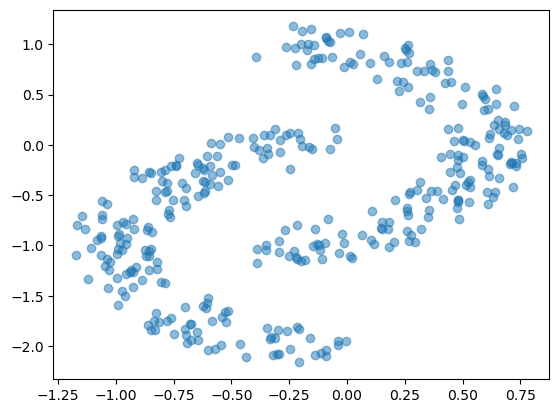

In [6]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

In [7]:
distance_mat(X,X)

array([[0.        , 1.49897716, 0.09012645, ..., 1.04943538, 0.98203886,
        1.41579385],
       [1.49897716, 0.        , 1.53457788, ..., 1.12911227, 1.45921414,
        2.46125257],
       [0.09012645, 1.53457788, 0.        , ..., 1.13477599, 1.0721651 ,
        1.47886127],
       ...,
       [1.04943538, 1.12911227, 1.13477599, ..., 0.        , 0.35315098,
        1.38444188],
       [0.98203886, 1.45921414, 1.0721651 , ..., 0.35315098, 0.        ,
        1.03129561],
       [1.41579385, 2.46125257, 1.47886127, ..., 1.38444188, 1.03129561,
        0.        ]])

In [8]:
dist = distance_matrix(X,X)
dist.shape

(360, 360)

In [9]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import collections


In [10]:
centers = None
print(centers is None)

True


In [11]:
def constructKnots(X, centers = None, labels = None, k = None, rep = 100):

  n, d = X.shape
  #construct knots
  if centers is None and labels is None:
    # Overfitting k-means
    #setting the number of knots k
    if k is None:
      k = round(math.sqrt(n))

    km = KMeans(n_clusters = k, n_init = rep)
    km.fit(X)
    centers = km.cluster_centers_
    labels = km.labels_

  elif labels is None:#centers provided but not labels
    nbrs = NearestNeighbors(n_neighbors=1).fit(centers)
    labels = nbrs.kneighbors(X, return_distance=False)
    k = len(centers)
    
  elif centers is None:#labels provided but not centers
    elements_count = collections.Counter(labels)
    k = len(elements_count.items())
    centers = np.array([[0.0 for col in range(d)] for row in range(k)])
    for key, value in elements_count.items():
      centers[key,] = np.mean(X[labels == key,], axis=0)

  else:
    k = len(centers)
  

  withinss = np.array([0.0]*k)
  for i in range(k):
    withinss[i] = np.sum((X[labels == i,]-centers[i,])**2)

  return {"centers":centers, "cluster":labels, "nknots":k, "withinss": withinss}

In [12]:
conKnots = constructKnots(X)

In [13]:
knots = conKnots["centers"]
knotlabels = conKnots["cluster"]
k = conKnots["nknots"]
withinss = conKnots["withinss"]

In [14]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

In [15]:
def skelWeights(X, conKnots, wedge= "all", h = "silverman", R0 = None, idx_frustum = False):
  m = conKnots["nknots"]
  knots = conKnots["centers"]
  knotlabels = conKnots["cluster"]
  withinss = conKnots["withinss"]

  #identify what edge weights to include
  edge_include = [False]*4
  if wedge == 'all':
    edge_include = [True]*4
  else:
    edge_include = np.isin(['voronoi', 'face', 'frustum', 'avedist'], wedge )
  
  #edge weight matrices
  if edge_include[0]:
    voron_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
  if edge_include[1]:
    face_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
  if edge_include[3]:
    avedist_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
  if edge_include[2]:
    frustum_weights = np.array([[0.0 for col in range(m)] for row in range(m)])
    ### setting the threshold for each disk
    if R0 is None: #fill in average within cluster variance if not specified
      elements_count = collections.Counter(knotlabels)
      knotsizes = np.array([0]*m)
      for key, size in elements_count.items():
        knotsizes[key] = size
      R_cluster = np.sqrt(withinss/(knotsizes-1))
      R0 = np.mean(R_cluster)
      if idx_frustum: #same radius for all knots
        R0_lv = np.array([R0]*m)
      else: #different radius for each knot
        R0_lv = R_cluster
    elif len(R0)== 1: # only one specified R0
      R0_lv = np.array([R0]*m)
      idx_frustum = True
    elif len(R0) == m:
      R0_lv = R0
      idx_frustum = False
    else:
      elements_count = collections.Counter(knotlabels)
      knotsizes = np.array([0]*m)
      for key, size in elements_count.items():
        knotsizes[key] = size
      R_cluster = np.sqrt(withinss/(knotsizes-1))
      R0 = np.mean(R_cluster)
      if idx_frustum: #same radius for all knots
        R0_lv = np.array([R0]*m)
      else: #different radius for each knot
        R0_lv = R_cluster



  # calculate 2 Nearest Neighbor Indices
  nbrs = NearestNeighbors(n_neighbors=2).fit(knots)
  X_nn = nbrs.kneighbors(X, return_distance=False) #2-nearest neighbor calculation

  for i in range(m-1): #loop through knots pairs
    center1 = knots[i]
    wi1 = np.where(X_nn[:,0] == i)[0]
    wi2 = np.where(X_nn[:,1] == i)[0]
    for j in range(i+1,m):
      center2 = knots[j]
      wj1 = np.where(X_nn[:,0] == j)[0]
      wj2 = np.where(X_nn[:,1] == j)[0]
      #data point indices within 2nn neighborhood of knots i, j
      nn2ij = np.union1d(np.intersect1d(wi1, wj2), np.intersect1d(wi2, wj1))
  
      if len(nn2ij) < 1 :#not in Delaunnay Triangulation
        if edge_include[0]:
          voron_weights[i,j] = 0.0
        if edge_include[1]:
          face_weights[i,j] = 0.0
        if edge_include[2]:
          frustum_weights[i,j] = 0.0
        if edge_include[3]:
          avedist_weights[i,j] = 0.0
        continue
      
      # Euclidean distance between two centers
      d12 = np.sqrt(sum((center1-center2)**2))

      #compute the Voronoi density 
      if edge_include[0]: 
        voron_weights[i,j] = len(nn2ij)/d12
      
      #compute the face density
      if edge_include[1]:
        v0 = (center2-center1)/d12 #direction vector
        X_ij = X[np.union1d(wi1, wj1)]
        p0_length = np.dot(X_ij-(center1+center2)/2,v0 )  #projected distance to middle point of the edge
        p_dot = p0_length/d12 #standardize the projected distances into proportions
        
        kde = gaussian_kde(p_dot, bw_method=h) #KDE with projected points
        face_weights[i,j] = kde.evaluate([0]) #interpolated density at middle point
        #end face density calculation
      
      #compute tube density
      if edge_include[2]: 
        if not edge_include[1]: # recompute some quantities in Face density calculation
          v0 = (center2-center1)/d12 #direction vector
          X_ij = X[np.union1d(wi1, wj1)]

        p1_length = np.dot(X_ij-center1,v0 )  # length to center1 after projection
        p1_dot = p1_length/d12 #standardize the projected distances into proportions
        perp_length = np.sqrt(np.sum((X_ij -center1)**2, axis=1)-p1_length**2) #orthogonal distance to the center-passing line
    
        #threshold for each datapoint
        R0_threshold = R0_lv[i] + (R0_lv[j]-R0_lv[i])*p1_dot
        w_edge = np.where(perp_length<R0_threshold)#points that can be used in KDE
        
        if len(w_edge)>1: #KDE works with more than 1 data point
          kde = gaussian_kde(p1_dot[w_edge], bw_method=h) #KDE with projected points
          # finding the minimal density
          frustum_weights[i,j] = min(kde.evaluate(np.linspace(0.0, 1.0, num=100)))
      #end frustum density calculation

      # compute avedist density
      if edge_include[3]: 
        dists = distance_matrix(X[wi1,], X[wj1,])
        avedist_weights[i,j] = np.mean(dists)
      #end avedist density

  output = {}
  if edge_include[0]:
    output.update( {"voron_weights": voron_weights + np.transpose((voron_weights))})
  if edge_include[1]:
    output.update( {"face_weights": face_weights + np.transpose((face_weights))})
  if edge_include[2]:
    output.update( {"frustum_weights": face_weights + np.transpose((frustum_weights))})
    output.update( {"R": R0_lv})
  if edge_include[3]:
    output.update( {"avedist_weights": avedist_weights })
  
  return(output)
  
    
    

In [16]:
def Skeleton_Construction(X, centers = None, labels = None, k = None, rep = 100, 
                            wedge= "all", h = "silverman", R0 = None, idx_frustum = False):

    conKnots = constructKnots(X, centers, labels, k, rep = 100)
    output = conKnots
    if wedge is not None:
        edgeWeights = skelWeights(X, conKnots, wedge, h, R0, idx_frustum)
        output.update(edgeWeights)
    return(output)

        


In [17]:
skeleton = Skeleton_Construction(X)

In [75]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_rand_score

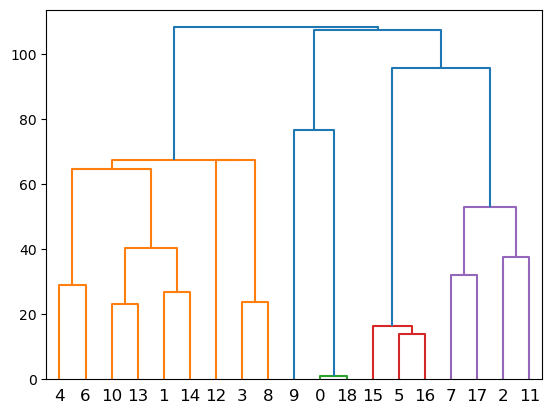

In [61]:
p_dist = np.max(skeleton["voron_weights"])+1 - skeleton["voron_weights"]
np.fill_diagonal(p_dist, 0.0)
condense_dist= squareform(p_dist, checks=False)
hclust = linkage(condense_dist, "single")
dendrogram(hclust)
plt.show()

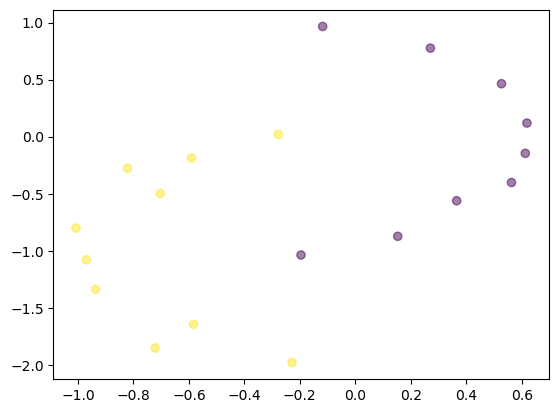

In [67]:
knots = skeleton["centers"]
plt.scatter(knots[:,0], knots[:,1], alpha=0.5, c = voron_labels)
plt.show()

In [ ]:
### Voronoi density
p_dist = np.max(skeleton["voron_weights"])+1 - skeleton["voron_weights"]
np.fill_diagonal(p_dist, 0.0)
condense_dist= squareform(p_dist, checks=False)
hclust = linkage(condense_dist, "single")
dendrogram(hclust)
plt.show()
voron_labels = fcluster(hclust, 2, criterion='maxclust') # membership for knots
X_labs = np.array(voron_labels)[np.array(skeleton["cluster"])] # labels for each data point
voron_rand = adjusted_rand_score(X_labs, Y)


In [90]:
def cluster_weights(weights, knotcluster, Y, kcut, method="single"):
    p_dist = np.max(weights)+1 - weights
    np.fill_diagonal(p_dist, 0.0)
    condense_dist= squareform(p_dist, checks=False)
    hclust = linkage(condense_dist, method)
    knot_labs = fcluster(hclust, kcut, criterion='maxclust') # membership for knots
    X_labs = np.array(voron_labels)[np.array(knotcluster)] # labels for each data point
    adj_rand = adjusted_rand_score(X_labs, Y)
    return({"hclust":hclust, "knot_labs":knot_labs, "X_labs":X_labs, "adj_rand":adj_rand})

In [91]:
voron_clus = cluster_weights(skeleton["voron_weights"], skeleton["cluster"], Y, 2)

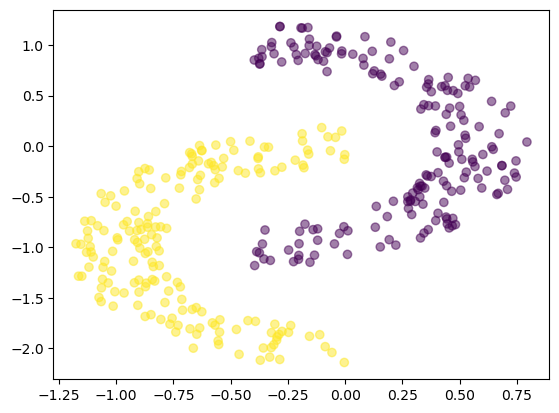

In [94]:
plt.scatter(X[:,0], X[:,1], alpha=0.5, c = voron_clus["X_labs"])
plt.show()